# Objectives

In this lab, we focus on **building regression models** to analyze wage differences. Specifically, we explore:

- **Transforming variables** (e.g., log transformation of wages)
- **Incorporating categorical variables** (e.g., gender effects)
- **Adding interaction terms** to capture varying relationships (e.g., how wage growth differs by gender)
- **Modeling non-linearity** (e.g., quadratic terms for age)

Regression models help us **quantify relationships** between variables, make **predictions**, and test **hypotheses**. By systematically incorporating transformations, categorical variables, and interactions, we improve our ability to **interpret patterns** in data and make **data-driven decisions**.


# Instructions

- Complete all **subsection tasks** in the Jupyter Notebook.  
- Save your **final notebook as a PDF** with all code executed and outputs visible.  
- Upload the PDF to **Gradescope** (link on Brightspace).

# Prelims

Let us first mount folder with files and change the working directory to where the files are. Make sure to replace the folder name below with the path in your Google Drive.

In [66]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Replace the path the actual folder name
os.chdir('/content/drive/MyDrive/DSO530Public/data')

# Confirm that the files are accessible
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['wages.csv',
 'census2000.csv',
 'anscombe.csv',
 'confood.csv',
 'pickup.csv',
 'sales.csv',
 'grades.csv',
 'telemarketing.csv',
 'imports.csv',
 'diamonds.csv',
 'supervisor.csv',
 'lab1',
 '<path_to_output_folder>']

Load packages

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

This code snippet below is setting the default size for plots (figures) that are created using the `matplotlib.pyplot` library.

In [68]:
# set the figure width and height
fig_height = 6
fig_width = fig_height * 1.618
plt.rcParams['figure.figsize'] = (fig_width, fig_height)

# Convert Notebook to PDF

You can use the following to convert your Notebook to a PDF

In [69]:
!apt-get install -y pandoc
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-plain-generic is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


Do not forget to change the path below.

In [70]:
!jupyter nbconvert --to pdf "<path_to_my_notebook>/Case\ Study\ In\ Interacations\ \(lab\).ipynb" --output-dir="<path_to_output_folder>"


[NbConvertApp] WARNING | pattern '<path_to_my_notebook>/Case\\ Study\\ In\\ Interacations\\ \\(lab\\).ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equ

# Case study in interaction

Use census data to explore the relationship between **log wage rate** (`log(income/hours)`) and **age**—a proxy for experience.


Let us first load the data.

In [71]:
# Load the data
census = pd.read_csv("census2000.csv")
census.head()

,age,sex,marital,race,education,income,hours
0,48,M,Married,White,3.hsgrad,52000,2600
1,24,M,Divorced,White,2.high,35000,2080
2,19,F,Single,Black,3.hsgrad,2400,240
3,18,M,Single,Black,2.high,6100,1500
4,28,M,Married,Other,4.assoc,22000,2080


In [72]:
#  give names of all columns
census.columns

Index(['age', 'sex', 'marital', 'race', 'education', ' income', 'hours'], dtype='object')

In [73]:
# rename columns " income" to "income"
census.rename(columns={" income": "income"}, inplace=True)

In [74]:
# summarize numerical variables
census.describe()

,age,income,hours
count,31402.000000,31402.000000,31402.000000
mean,40.335361,32099.931629,1973.679638
std,12.843879,37412.099182,703.049875
min,18.000000,1.000000,24.000000
25%,30.000000,12000.000000,1680.000000
50%,40.000000,25000.000000,2080.000000
75%,49.000000,40000.000000,2304.000000
max,93.000000,372000.000000,5096.000000


In [75]:
# what levels do categorical variables have
for col in ["sex", "marital", "race", "education"]:
    print(col, census[col].unique())

sex ['M' 'F']
marital ['Married' 'Divorced' 'Single' 'Separated' 'Widow']
race ['White' 'Black' 'Other' 'Asian' 'NativeAmerican']
education ['3.hsgrad' '2.high' '4.assoc' '5.bachs' '7.profdeg' '8.phd' '6.mstr'
 '1.grade' '0.none']


**Census Data Variables**

- **`age`**: The age of the individual in years.
- **`sex`**: The gender of the individual (typically `"M"` for male and `"F"` for female).
- **`marital`**: Marital status (e.g., `"Single"`, `"Married"`, `"Divorced"`, etc.).
- **`race`**: Racial or ethnic background (e.g., `"White"`, `"Black"`, `"Other"`, etc.).
- **`education`**: The highest level of education attained (e.g., `"0.none"`, `"1.grade"`, etc.).
- **`income`**: Total annual income earned by the individual (in dollars).
- **`hours`**: Total number of hours worked in a year.

These variables are used to analyze wage disparities based on age, gender, education, and other demographic factors.


We focus on **active, full-time** workers:

- `hours > 500`: Excludes part-time or sporadic workers.
- `income > 5000`: Removes extremely low earners to avoid distortions.
- `age < 60`: Excludes retirees and older individuals who may work part-time.

In [76]:
# Filter workers based on conditions
workers = (census["hours"] > 500) & (census["income"] > 5000) & (census["age"] < 60)

We take the log of the wage rate (income per hour) for several reasons:

- Normalizes the distribution: Income data is typically right-skewed. Taking the log makes it more symmetric.
- Reduces heteroskedasticity: Variability in wages often increases with higher incomes. Logging the wage rate stabilizes variance and makes regression assumptions more valid.

In [77]:
# Compute log wage rate
log_WR = np.log(census["income"] / census["hours"])[workers]

Compare the histograms

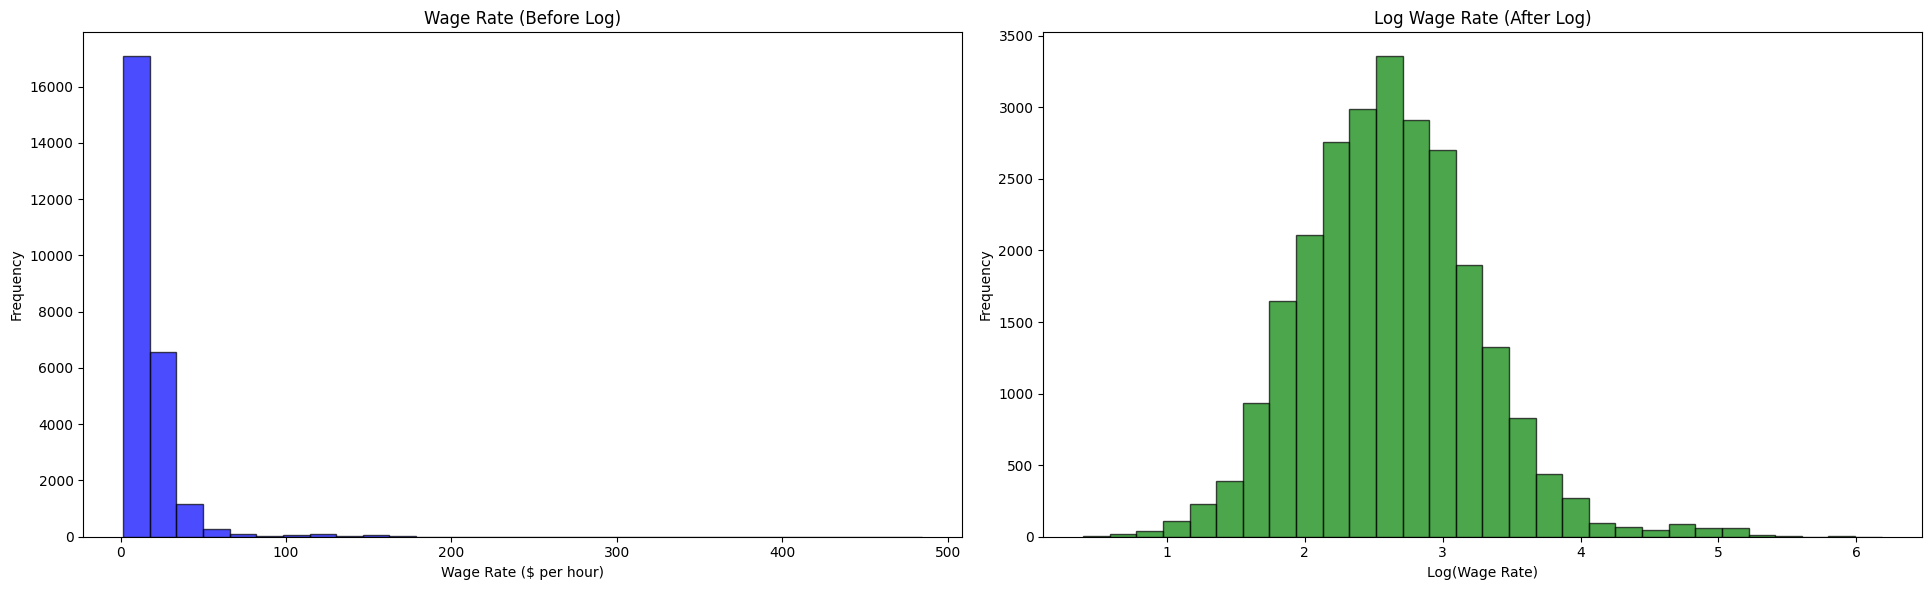

In [78]:
# Compute wage rate
WR = (census["income"] / census["hours"])[workers]

# Plot histograms before and after log transformation
fig, axes = plt.subplots(1, 2, figsize=(fig_width*2, fig_height))

# Histogram of raw wage rate
axes[0].hist(WR[workers], bins=30, color="blue", alpha=0.7, edgecolor="black")
axes[0].set_title("Wage Rate (Before Log)")
axes[0].set_xlabel("Wage Rate ($ per hour)")
axes[0].set_ylabel("Frequency")

# Histogram of log wage rate
axes[1].hist(log_WR[workers], bins=30, color="green", alpha=0.7, edgecolor="black")
axes[1].set_title("Log Wage Rate (After Log)")
axes[1].set_xlabel("Log(Wage Rate)")
axes[1].set_ylabel("Frequency")

# Adjust layout and show
plt.tight_layout()
plt.show()

The right histogram looks more "normal".

We will investigate such transformations in more details in the next class.

Next, let us visualize the distribution of log wage rates (`log_WR`) across different age groups for each gender.

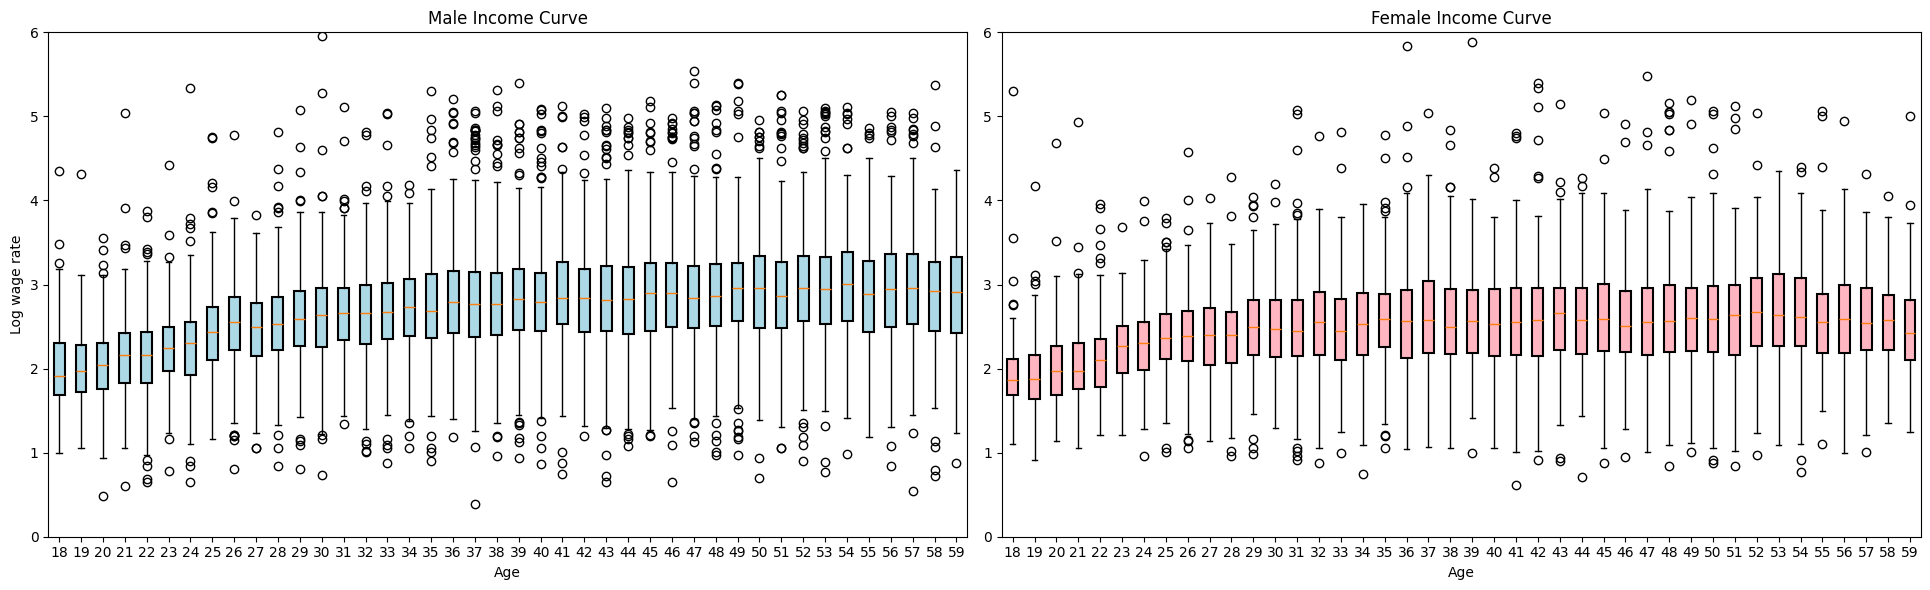

In [79]:
age = census["age"][workers]
sex = census["sex"][workers]

# Boxplots for male and female income
fig, axes = plt.subplots(1, 2, figsize=(fig_width*2, fig_height))

# Male income boxplot
male_log_WR = log_WR[sex == "M"]
male_age = age[sex == "M"]
box = axes[0].boxplot([male_log_WR[male_age == a] for a in sorted(male_age.unique())],
                positions=sorted(male_age.unique()), patch_artist=True )
# Change box colors
for patch in box['boxes']:
    patch.set(facecolor="lightblue", edgecolor="black", linewidth=1.5)  # Set fill and edge color
axes[0].set_title("Male Income Curve")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Log wage rate")
axes[0].set_ylim(0, 6)

# Female income boxplot
female_log_WR = log_WR[sex == "F"]
female_age = age[sex == "F"]
box = axes[1].boxplot([female_log_WR[female_age == a] for a in sorted(female_age.unique())],
                positions=sorted(female_age.unique()), patch_artist=True)
# Change box colors
for patch in box['boxes']:
    patch.set(facecolor="lightpink", edgecolor="black", linewidth=1.5)  # Set fill and edge color
axes[1].set_title("Female Income Curve")
axes[1].set_xlabel("Age")
axes[1].set_ylim(0, 6)

plt.tight_layout()
plt.show()

Let us obtain a nonparametric fit.

This fit shows the average log wage rate for men and women across different age groups.

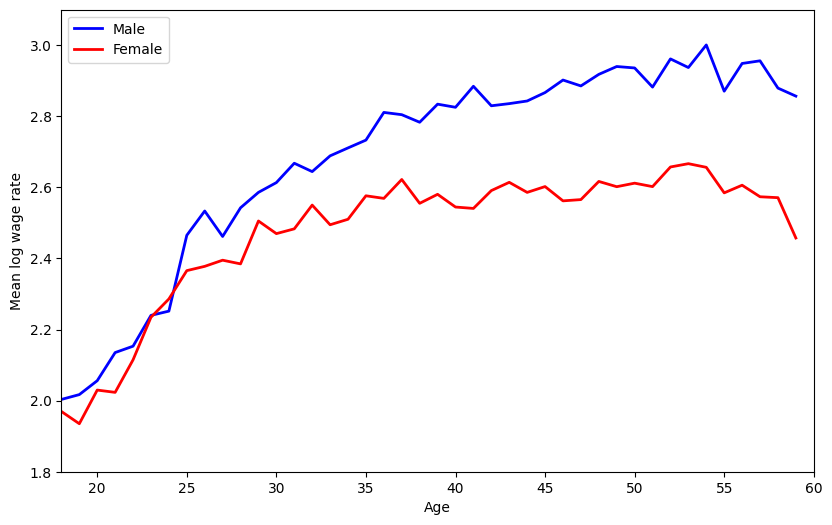

In [80]:
# Compute mean wage at each age level
men = sex == "M"
malemean = log_WR[men].groupby(age[men]).mean()
femalemean = log_WR[~men].groupby(age[~men]).mean()

# Plot mean log wage rates
plt.figure()
plt.plot(malemean.index, malemean.values, color="blue", linewidth=2, label="Male")
plt.plot(femalemean.index, femalemean.values, color="red", linewidth=2, label="Female")
plt.xlabel("Age")
plt.ylabel("Mean log wage rate")
plt.xlim(18, 60)
plt.ylim(1.8, 3.1)
plt.legend()

plt.show()

A discrepancy between mean $\log(\mathrm{WR})$ for men and women.

- Female wages flatten at about 30, while men's keep rising.


**Can we build a simple, interpretable model that summarizes the observation above**?

What is the **goal**?

When constructing regression models, the objective depends on the type of question we want to answer.

1. Relationship-type questions and inference?

  - Are women paid differently than men on average?
  - Does age/experience differently affect men and women?

2. Data summarization?

  - Matched the dynamics/trends
  - Describe a past phenomenon

3. Prediction?

  - Need a fair, objective criterion that matches the idea of predicting the future. Avoid overfitting.

In [81]:
# let us create a new DataFrame that has log_WR, age, men for workers
workers_df = pd.DataFrame({"log_WR": log_WR, "age": age, "men": men})
workers_df.head()

,log_WR,age,men
0,2.995732,48,True
1,2.822980,24,True
3,1.402824,18,True
4,2.358675,28,True
6,2.407465,40,False


In [82]:
def add_means_to_plot(axis, malemean, femalemean):
  """Adds the mean log wage rates for males and females to an existing plot.

  This function takes two pandas Series, `malemean` and `femalemean`,
  representing the mean log wage rates for males and females at different ages,
  and adds them to the current matplotlib plot.  It assumes that the indices
  of these Series correspond to age values and that a plot is already active.

  Args:
      axis: matplotlib axis to plot on. If None, uses current axis.
      malemean: A pandas Series containing the mean log wage rates for males at different ages.
      femalemean: A pandas Series containing the mean log wage rates for females at different ages.
  """
  axis.plot(malemean.index, malemean.values, color="blue", linewidth=2, linestyle="--", label="Male Mean")
  axis.plot(femalemean.index, femalemean.values, color="red", linewidth=2, linestyle="--", label="Female Mean")
  axis.set_xlabel("Age")
  axis.set_ylabel("Mean log wage rate")
  axis.set_xlim(18, 60)
  axis.set_ylim(1.8, 3.1)
  axis.legend()


This code defines a function called `add_means_to_plot`. Its purpose is to add lines representing the mean (average) log wage rates for males and females to an existing plot. We will see it in action below.

# Model Building

We will build few models together. We start from the simplest possible model.

For reference on how to use formulas used in model fitting in Python, you can check https://www.statsmodels.org/dev/example_formulas.html

## Simplest Model

First we can start by a simple linear model.

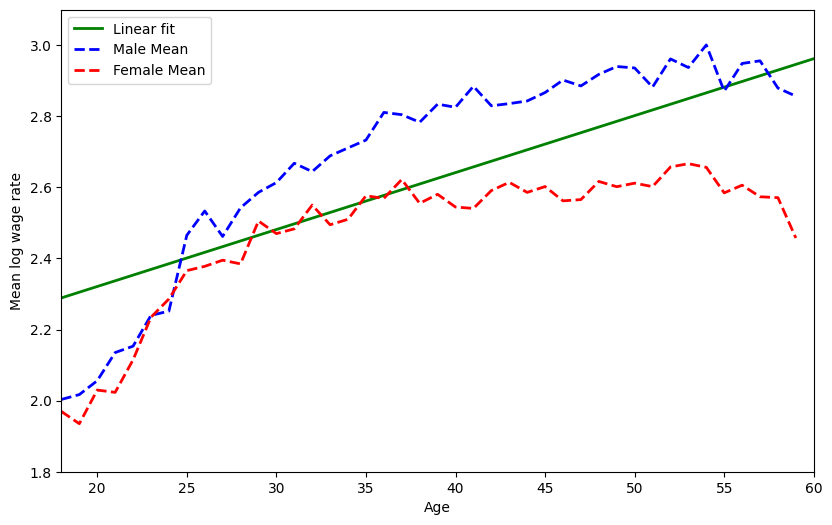

In [83]:
grid = np.linspace(18, 60, 100)

# Fit a linear model of log_WR onto age
wagereg1 = smf.ols("log_WR ~ age", data=workers_df).fit()

# visualize the fit
fig, ax = plt.subplots()
ax.plot(grid, wagereg1.predict(pd.DataFrame({"age": grid})), color="green", linewidth=2, label="Linear fit")
add_means_to_plot(ax, malemean, femalemean)
plt.show()

You get one line for both men and women. This model does not provide a good explanation.

In [84]:
# print the summary for the fit
print( wagereg1.summary() )

                            OLS Regression Results                            
Dep. Variable:                 log_WR   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2016.
Date:                Thu, 06 Feb 2025   Prob (F-statistic):               0.00
Time:                        04:08:06   Log-Likelihood:                -23321.
No. Observations:               25403   AIC:                         4.665e+04
Df Residuals:                   25401   BIC:                         4.666e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0006      0.014    139.480      0.0

We have learned the following model.

In [85]:
# print E[log(WR)] = intercept + slope x age
intercept = wagereg1.params["Intercept"]
slope = wagereg1.params["age"]
print(f"E[log(WR)] = {intercept:.3f} + {slope:.3f} x age")

E[log(WR)] = 2.001 + 0.016 x age


## Adding Sex Effect

### **Task**:

Fit a model that includes the effect of `sex`.

That is, build a model E[log(WR)] = b0 + b1 x age + b2 x ind(men = T)

In [86]:
#TODO: build a linear model for log_WR using age and sex
wagereg2 = smf.ols("log_WR ~ age + men", data=workers_df).fit()

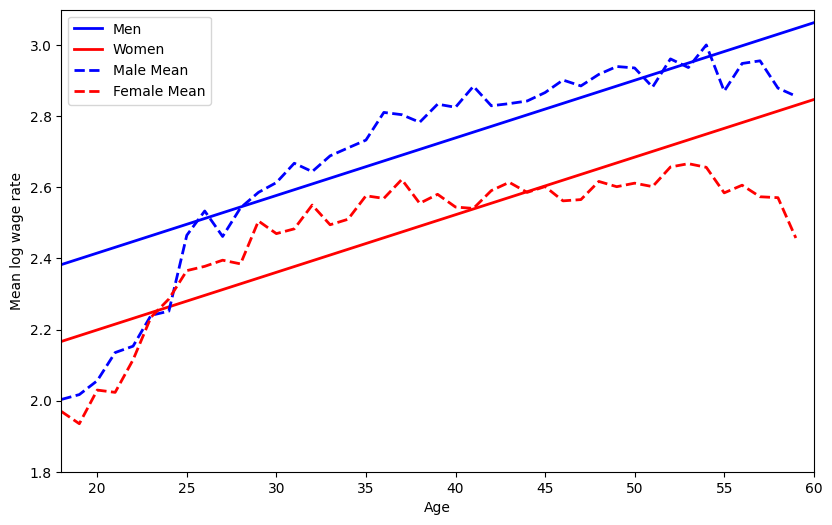

In [87]:
# TODO: Visualize the fit
fig, ax = plt.subplots()

# Predict for men
ax.plot(grid, wagereg2.predict(pd.DataFrame({"age": grid, "men": True})), color="blue", linewidth=2, label="Men")

# Predict for women
ax.plot(grid, wagereg2.predict(pd.DataFrame({"age": grid, "men": False})), color="red", linewidth=2, label="Women")

# Add the mean lines
add_means_to_plot(ax, malemean, femalemean)
plt.show()

In the plot above, you should see that:

- The male wage line is shifted up from the female line.

In [88]:
# print the summary for the fit
print(wagereg2.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_WR   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     1454.
Date:                Thu, 06 Feb 2025   Prob (F-statistic):               0.00
Time:                        04:08:06   Log-Likelihood:                -22914.
No. Observations:               25403   AIC:                         4.583e+04
Df Residuals:                   25400   BIC:                         4.586e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.8750      0.015    126.880      

### **Task**:

What model did you estimate above?

In [89]:
# TODO: print the coefficients of the model E[log(WR)] = b0 + b1 x age + b2 x ind(men = T)
intercept = wagereg2.params["Intercept"]
slope_age = wagereg2.params["age"]
slope_men = wagereg2.params["men[T.True]"]

print(f"E[log(WR)] = {intercept:.3f} + {slope_age:.3f} x age + {slope_men:.3f} x men[T.True]")

E[log(WR)] = 1.875 + 0.016 x age + 0.216 x men[T.True]


## Add Interactions between sex and age

### **Task**:

Fit a model that includes interactions between `sex` and `age`.

That is, build a model E[log(WR)] = b0 + b1 x age + (b2 + b3 x age) x men[T.True]

In [90]:
# TODO: Fit a model that includes interactions between `sex` and `age`.
wagereg3 = smf.ols("log_WR ~ age + C(men)*age", data=workers_df).fit()

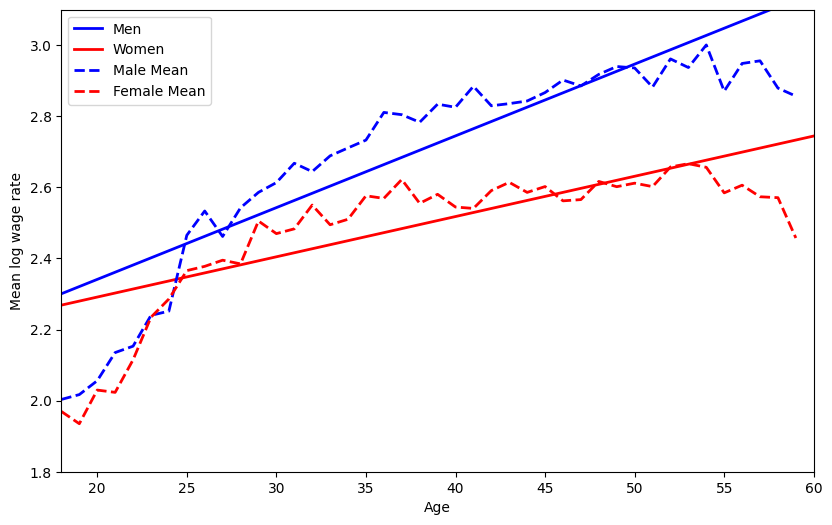

In [91]:
# TODO: Visualize the fit
fig, ax = plt.subplots()

# Predict for men
ax.plot(grid, wagereg3.predict(pd.DataFrame({"age": grid, "men": True})), color="blue", linewidth=2, label="Men")

# Predict for women
ax.plot(grid, wagereg3.predict(pd.DataFrame({"age": grid, "men": False})), color="red", linewidth=2, label="Women")

# Add the mean lines
add_means_to_plot(ax, malemean, femalemean)
plt.show()

In the plot above, you should see that:

- The interaction term gives us different slopes for each sex.

In [92]:
# print the summary for the fit
print(wagereg3.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_WR   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     1028.
Date:                Thu, 06 Feb 2025   Prob (F-statistic):               0.00
Time:                        04:08:07   Log-Likelihood:                -22835.
No. Observations:               25403   AIC:                         4.568e+04
Df Residuals:                   25399   BIC:                         4.571e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.0649      0

### **Task**:

What model did you estimate above?

In [93]:
# TODO: print the coefficients of the model E[log(WR)] = b0 + b1 x age + (b2 + b3 x age) x men[T.True]
intercept = wagereg3.params["Intercept"]
slope_age = wagereg3.params["age"]
slope_men = wagereg3.params["C(men)[T.True]"]
slope_interaction = wagereg3.params["C(men)[T.True]:age"]

print(f"E[log(WR)] = {intercept:.3f} + {slope_age:.3f} x age + ({slope_men:.3f} + {slope_interaction:.3f} x age) x men[T.True]")

E[log(WR)] = 2.065 + 0.011 x age + (-0.128 + 0.009 x age) x men[T.True]


## Add quadratics to the model

### **Task**:

Fit a model that also includes a quadratic term $age^2$.

In [94]:
# TODO: Fit a model that includes interactions between `sex` and `age` and quadratic term age^2
wagereg4 = smf.ols("log_WR ~ age + I(age**2) + C(men)*age", data=workers_df).fit()

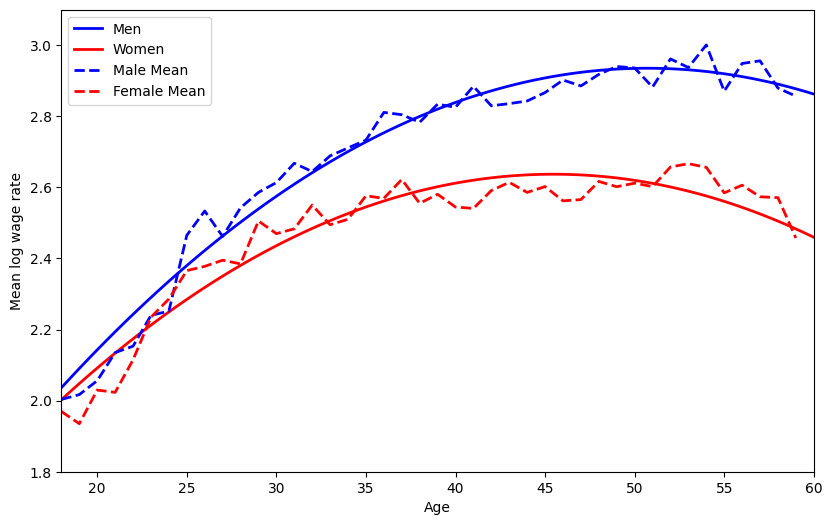

In [95]:
# TODO: Visualize the fit
fig, ax = plt.subplots()

# Predict for men
ax.plot(grid, wagereg4.predict(pd.DataFrame({"age": grid, "men": True})), color="blue", linewidth=2, label="Men")

# Predict for women
ax.plot(grid, wagereg4.predict(pd.DataFrame({"age": grid, "men": False})), color="red", linewidth=2, label="Women")

# Add the mean lines
add_means_to_plot(ax, malemean, femalemean)
plt.show()

In the plot above, you should see that:

- $age^2$ allows us to capture a nonlinear wage curve.

In [96]:
# print the summary for the fit
print(wagereg4.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_WR   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     959.8
Date:                Thu, 06 Feb 2025   Prob (F-statistic):               0.00
Time:                        04:08:07   Log-Likelihood:                -22503.
No. Observations:               25403   AIC:                         4.502e+04
Df Residuals:                   25398   BIC:                         4.506e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.8989      0

### **Task**:

What model did you estimate above?

In [97]:
# TODO: print the coefficients of the model  E[log(WR)] = b0 + b1 x age + b4 x age^2 + (b2 + b3 x age) x men[T.True]
intercept = wagereg4.params["Intercept"]
slope_age = wagereg4.params["age"]
slope_men = wagereg4.params["C(men)[T.True]"]
slope_interaction = wagereg4.params["C(men)[T.True]:age"]
slope_age_squared = wagereg4.params["I(age ** 2)"]

print(f"E[log(WR)] = {intercept:.3f} + {slope_age:.3f} x age + {slope_age_squared:.3f} x age^2 + ({slope_men:.3f} + {slope_interaction:.3f} x age) x men[T.True]")

E[log(WR)] = 0.899 + 0.076 x age + -0.001 x age^2 + (-0.125 + 0.009 x age) x men[T.True]


## Add an interaction term on the curvature

### **Task**:

Fit a model that also includes an interaction between $age^2$ and `sex`.

In [98]:
# TODO: Fit a model that also includes an interaction between $age^2$ and `sex`.
wagereg5 = smf.ols("log_WR ~ age + I(age**2) + C(men)*(age + I(age**2))", data=workers_df).fit()

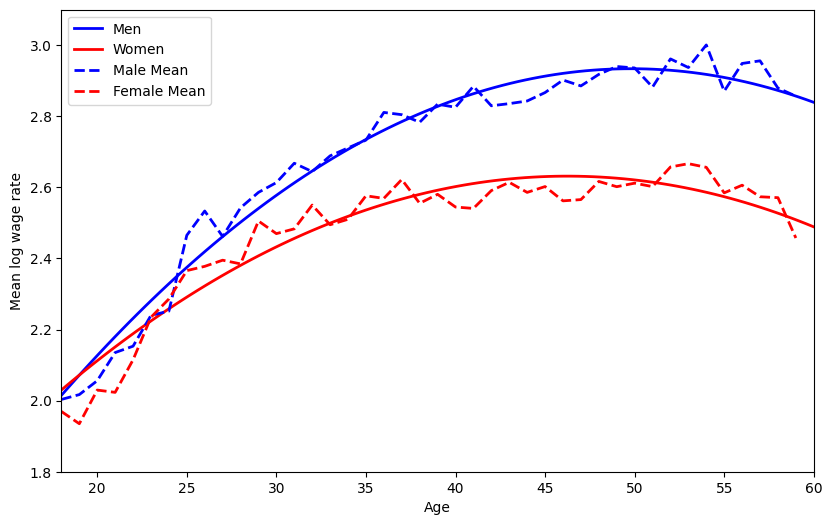

In [99]:
# TODO: Visualize the fit
fig, ax = plt.subplots()

# Predict for men
ax.plot(grid, wagereg5.predict(pd.DataFrame({"age": grid, "men": True})), color="blue", linewidth=2, label="Men")

# Predict for women
ax.plot(grid, wagereg5.predict(pd.DataFrame({"age": grid, "men": False})), color="red", linewidth=2, label="Women")

# Add the mean lines
add_means_to_plot(ax, malemean, femalemean)
plt.show()

In the plot above, you should see that:

- This full model provides a generally decent looking fit.

In [100]:
# print the summary for the fit
print(wagereg5.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_WR   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     769.1
Date:                Thu, 06 Feb 2025   Prob (F-statistic):               0.00
Time:                        04:08:08   Log-Likelihood:                -22500.
No. Observations:               25403   AIC:                         4.501e+04
Df Residuals:                   25397   BIC:                         4.506e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### **Task**:

What model did you estimate above?

In [101]:
# TODO: print the coefficients of the estimated model

intercept = wagereg5.params["Intercept"]
slope_age = wagereg5.params["age"]
slope_men = wagereg5.params["C(men)[T.True]"]
slope_interaction = wagereg5.params["C(men)[T.True]:age"]
slope_age_squared = wagereg5.params["I(age ** 2)"]
slope_interaction_squared = wagereg5.params["C(men)[T.True]:I(age ** 2)"]

print(f"E[log(WR)] = {intercept:.2f} + {slope_age:.2f} x age + {slope_age_squared:.4f} x age^2 + ({slope_men:.2f} + {slope_interaction:.2f} x age + {slope_interaction_squared:.5f} x age^2) x men[T.True]")

E[log(WR)] = 1.02 + 0.07 x age + -0.0008 x age^2 + (-0.34 + 0.02 x age + -0.00015 x age^2) x men[T.True]


## Optional



### **Task:**

Consider building a model that has an interaction between age and edu.

In [102]:
# add edu into workers_df
workers_df["edu"] = census["education"][workers]

In [103]:
workers_df["edu"].unique()

array(['3.hsgrad', '2.high', '4.assoc', '5.bachs', '7.profdeg', '8.phd',
       '6.mstr', '1.grade', '0.none'], dtype=object)

You can first condsider visualizing average `log_WR` as a function of `edu` and `age`.

In [104]:
#TODO: build a linear model for log_WR using edu and age.
wagereg6 = smf.ols("log_WR ~ edu + age", data=workers_df).fit()

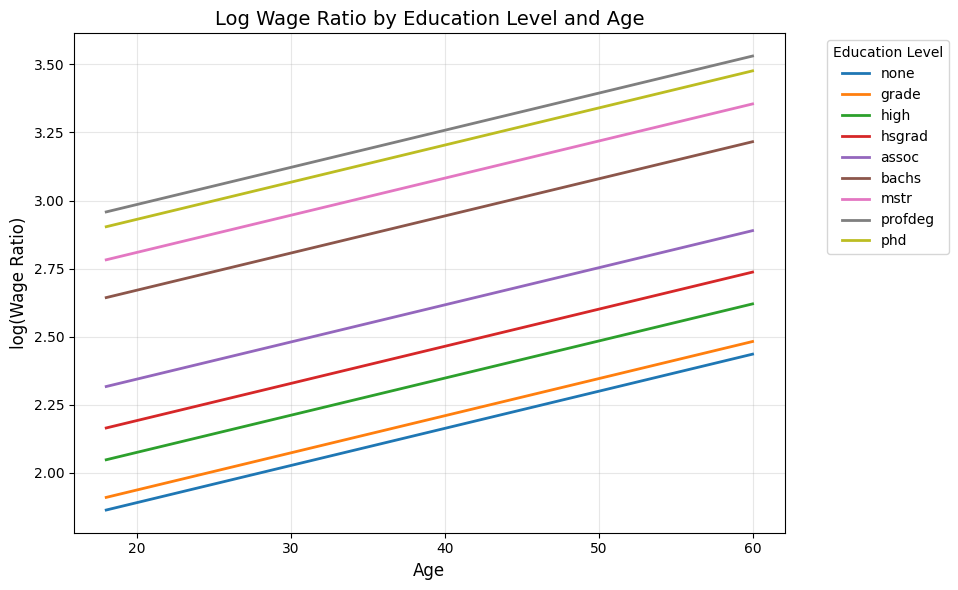

In [105]:
# TODO: Visualize the fit
fig, ax = plt.subplots()

# Define colors for different education levels
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

# Education levels in order
edu_levels = ['0.none', '1.grade', '2.high', '3.hsgrad', '4.assoc',
              '5.bachs', '6.mstr', '7.profdeg', '8.phd']

# Plot prediction for each education level
for i, edu in enumerate(edu_levels):
    predictions = wagereg6.predict(pd.DataFrame({
        "age": grid,
        "edu": [edu] * len(grid)
    }))
    ax.plot(grid, predictions, color=colors[i],
            linewidth=2, label=edu.split('.')[1])

# Customize the plot
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("log(Wage Ratio)", fontsize=12)
ax.set_title("Log Wage Ratio by Education Level and Age", fontsize=14)
ax.legend(title="Education Level", bbox_to_anchor=(1.05, 1),
         loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Subsequently, try building a simple, interpretable model for the average.

In [106]:
# print the summary for the fit
print(wagereg6.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_WR   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     833.4
Date:                Thu, 06 Feb 2025   Prob (F-statistic):               0.00
Time:                        04:08:09   Log-Likelihood:                -21004.
No. Observations:               25403   AIC:                         4.203e+04
Df Residuals:                   25393   BIC:                         4.211e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.6174      0.045  

In [107]:
# TODO: print the coefficients of the model.
intercept = wagereg6.params["Intercept"]
slope_age = wagereg6.params["age"]

# Extract education coefficients
edu_coeffs = {level: wagereg6.params[f"edu[T.{level}]"] for level in edu_levels[1:]}

# Print the model equation
print(f"E[log(WR)] = {intercept:.3f} + {slope_age:.3f} × age +")
for edu, coef in edu_coeffs.items():
    print(f"            {coef:.3f} × edu[T.{edu}] +")

E[log(WR)] = 1.617 + 0.014 × age +
            0.046 × edu[T.1.grade] +
            0.185 × edu[T.2.high] +
            0.301 × edu[T.3.hsgrad] +
            0.454 × edu[T.4.assoc] +
            0.780 × edu[T.5.bachs] +
            0.919 × edu[T.6.mstr] +
            1.095 × edu[T.7.profdeg] +
            1.041 × edu[T.8.phd] +
